https://simpleelastix.readthedocs.io/Introduction.html

### Image pyramids

Should use the `SmoothingImagePyramid` for downsampling: it smooths with a Gaussian kernel at different resolutions. Use with a random sampler, will be a good approximation to true gradient descent. Two important parameters: `NumberOfResolutions` and `ImagePyramidSchedule`. Schedule defines amount of blurring in x,y,z coordinates. Number of resolutions defines how many different resolutions will be used for blurring.

### Masking

Masking images allows irregularly-shaped regions of interest to be retain, in contrast to cropping where pixels are discarded and the image must be rectangular. When doing multi-resolution registration with masking, need to set `(ErodeMask "false")` in the case of lung registration, to allow information about the position of the lung edge to influence the registration. If the edge was purely technical (eg, the edge of ultrasound image), then should be set to "true" to prevent that information entering the registration. 

### Transformations

The number of degrees of freedom for rigid transformation in 3D space is 3, 12 for affine warping in 3D space, and >>12 (hundreds to millions) for nonlinear warping. The number of degrees of freedom corresponds to the computational complexity in finding a solution. 

### Metrics

The similarity metric provides the degree of similarity between moving and fixed images.

The mean squared difference (SSD) metric computes the mean squared pixel-wise intensity differences (optimal difference is zero).

Normalized correlation coefficient (NCC) computes pixel-wise cross-correlation normalized by the square root of the autocorrelation of the images. It is invariant ot linear differences between intensity distributions, so is well suited to CT where intensity scales are related by linear transformation between scanners. Cost function has sharp peaks and well-defined minima.

Mutual information (MI) is a measure of how of how much information one random variable (image intensity in one image) tells about a second random variable (intensity in the other image). Similar to correlation. Measures the dependency of the probability density distributions of the intensities.

Mattes mutual information is an implementation of MI that samples the same pixels at each iteration. This makes the path in search space more smooth.

Kappa similarity is used to register binary images and measures the overlap in segmented structures. In most cases it's better to convert the binary images to a distance map and use one of the other metrics.

### Optimizers

Available in SimpleElastix: gradient descent, robbins-monroe, adaptive stochastic gradient descent (recommended), conjugate descent, conjugate gradient FRPR, quasi-newton LBFGS, ....

### Samplers

Rather than calculating the metrics over the entire image, we can use a sampler to select as subset of locations to evaluate. We have grid, random, random coordinate and full sampling strategies in SimpleElastix, select with the `ImageSampler` parameter. Grid defines a grid on the fixed image and selects coordinates on the grid. 

### Interpolation

When evaluating sampled points in the fixed image space, the moving points will generally be mapped to a non-grid position, and so interpolation is required to evaluate image intensity at the mapped off-grid position. Can use nearest neighbors (`NearestNeighborInterpolator`; the most simple). Linear interpolation will return a weighted average of surrounding voxels using distances as weights (highly optimized in elastix, most popular method in combination with a random sampler). `BSplineInterpolator` interpolates using b-spline approximations.

In [1]:
import SimpleITK as sitk

In [43]:
fixedImage = sitk.ReadImage('/home/stuartt/github/ccf/data/simpleelastix_test/BrainProtonDensity.png', sitk.sitkFloat32)
movingImage = sitk.ReadImage('/home/stuartt/github/ccf/data/simpleelastix_test/BrainProtonDensityTranslatedR1013x17yS12.png', sitk.sitkFloat32)

In [91]:
parameterMap = sitk.GetDefaultParameterMap('affine')

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(parameterMap)
elastixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f7bef51fcf0> >

In [92]:
resultImage = elastixImageFilter.GetResultImage()

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

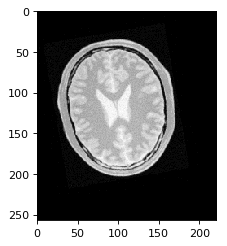

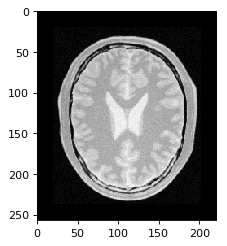

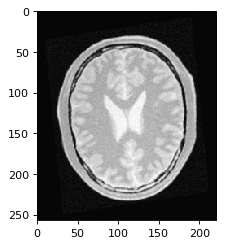

In [95]:
myshow(movingImage); myshow(fixedImage); myshow(resultImage)

## Parameter maps
The parameter map is a collection of key-value pairs that define components of the registration and their settings. They are typically specified as a tuple, although the second value may be multiple entries, eg `(ParameterName 4 4 4 5 5 5)`. The parameter map is initially populated with default values, which can be changed by assigning new ones or by changing settings in the class initialization:

In [97]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.PrintParameterMap()

<SimpleITK.SimpleITK.ElastixImageFilter; proxy of <Swig Object of type 'itk::simple::ElastixImageFilter::Self *' at 0x7f7bef670960> >

For some reason this doesn't print out the parameters as shown in the tutorial.

## Non-rigid registration

In [106]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)

parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)
elastixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f7beeb622d0> >

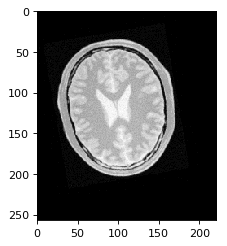

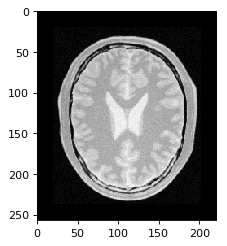

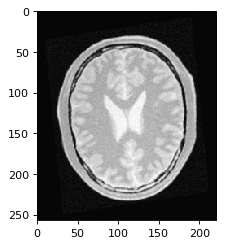

In [107]:
myshow(movingImage); myshow(fixedImage); myshow(resultImage)

## Point-based registration

Point-based registration allows us to use pre-defined sets of corresponding points to assist the registration. This is a way of embedding domain or expert knowledge into the registration procedure. Points can be defined through manual annotation or automatic segmentation. Use the `CorrespondingPointsEuclideanDistanceMetric` method to run a point-based registration (append it to the parameter map).

In [114]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.AddParameter( "Metric", "CorrespondingPointsEuclideanDistanceMetric" )

<SimpleITK.SimpleITK.ElastixImageFilter; proxy of <Swig Object of type 'itk::simple::ElastixImageFilter::Self *' at 0x7f7beeb17780> >

Specify a set of points in a text file with the "elastix" format (.pts extension):

```
<index, point>
<number of points>
point1 x point1 y [point1 z]
point2 x point2 y [point2 z]
```

Either "index" or "point" is specified at the beginning of the file to indicate whether the points are in pixel (index) or world (point) coordinates.

Here's an example that would align images using a set of points (no test data given so this is not run). We first compute an affine transform, then do non-linear warping using the points.

```python
# Compute the transformation
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.Execute()

# Warp point set. The transformed points will be written to a file named
# outputpoints.txt in the output directory determined by SetOutputDirectory()
# (defaults to working directory). The moving image is needed for transformix
# to correctly infer the dimensionality of the point set.
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(elastixImageFilter.GetTransformParameterMap())
transformixImageFilter.SetFixedPointSetFileName("fixedPointSet.pts")
transformixImageFilter.Execute()
```